In [6]:
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}


import pandas as pd 
import re
import matplotlib.pyplot as plt
import numpy as np
import codecs
import langdetect
import nltk

In [ ]:
#nltk.download()  # For langdetect to run, it may be necessary to run this line, and 
                  # install the nltk stopwords corpora (click the Corpora tab, select stopwords,
                  # then click download. Then close the window)

Proposal: RapItalia
-------------------

Living in Italy and observing how hip hop is a relatively new phenomenon here, I got interested in how coolness travels between cultures, with a delay. Something that could turn out to be very profitable. My hypothesis was that Italians began to develop a taste for rap music in about the mid 2000s (about 10 years after it became a powerful force in North American pop culture). 

To evaluate the popularity of rap in Italy over time, I used as a proxy the publication date of songs found on the Italian lyrics website [aztesti.it](http://aztesti.it). Although the process used to select songs is unknown, such websites are designed to optimize traffic, and so they offer a sample of songs regularly searched for by current users. Based on the title and site design, only Italian-speaking users. I wrote a custom web crawler to scrape the lyrics. This process ran into difficulties when, after a certain number of requests, my IP address was banned. I changed strategies, and sampled only the first song from each album of the top 100 artists, and increased the delay between accesses to once every 2 seconds. My IP address was still banned three more times, but I collected one song from 687 albums.

In [44]:
# Read in information about albums and tracks
album_tracks = pd.read_csv('albuminfo.txt','\t',names=['album','year','song'])
album_tracks = album_tracks.drop_duplicates()

# Find the first tracks
grouped = album_tracks.groupby(by='album')
first_song_info = grouped['album','year','song'].first()
first_song_info.index = range(len(first_song_info))

# Extract and process the text 
for i,songtitle in enumerate(first_song_info.song):
    filename = 'lyrics/' + songtitle + '.txt'
    try:
        with codecs.open(filename,'r','utf-8') as f:
            songtext = f.read()
            f.close()
    except IOError:
        print filename
        continue
    
    
    songtext = songtext.strip()
    re.sub('\r\n(\r\n)+','\r\n',songtext)
    
    words = songtext.split()
    first_song_info.loc[i,'word_count'] = len(words)
    first_song_info.loc[i,'num_lines']= songtext.count('\n')+1
    first_song_info.loc[i,'avg_word_length']= np.nanmean([len(x) for x in words])
    try:
        first_song_info.loc[i,'language'] = langdetect.whichLanguage(langdetect.scoreFunction(songtext))    
    except UnicodeDecodeError:
        first_song_info.loc[i,'language'] =np.nan

song_valid = np.all([np.invert(first_song_info.word_count.isnull()),first_song_info.word_count > 25],0)
first_song_info = first_song_info.loc[song_valid,:]

### Rap content
I built a crude genre classifier to judge whether a song was a rap song or not, based on the total number of words, with the cutoff being 500 words. If the first song on an album was a rap song, that album was categorized as a rap album. 

In [45]:
rapCutoff = 500  # Number of words in a single song to be classified as rap

first_song_info.loc[:,'is_rap'] = first_song_info.loc[:,'word_count'] > rapCutoff
print "These songs were identified as rap: "
print first_song_info.loc[first_song_info.is_rap,['song','word_count']].sort_values(by='word_count')

These songs were identified as rap: 
                                    song  word_count
244       si-tu-no-estas-testo-nicky-jam       505.0
254                mic-taser-testo-salmo       506.0
30              aka-testo-jennifer-lopez       507.0
372   attaccami-la-spina-testo-jovanotti       519.0
445                 scusa-testo-gemitaiz       519.0
448         play-hard-testo-david-guetta       525.0
687           civil-war-testo-gunsnroses       528.0
302          fucking-problem-testo-drake       534.0
623     its-like-that-testo-mariah-carey       541.0
624     its-like-that-testo-mariah-carey       541.0
216         el-chapo-testo-jake-la-furia       554.0
164             digital-girl-testo-drake       557.0
377                  sandm-testo-rihanna       561.0
523                triumph-testo-pitbull       567.0
507          deez-my-streets-testo-max-b       569.0
374         serenata-rap-testo-jovanotti       569.0
400             305-anthem-testo-pitbull       571.0
130      

Then I plotted the number of rap albums per year in the lyric database, along with the number of non-rap songs. 

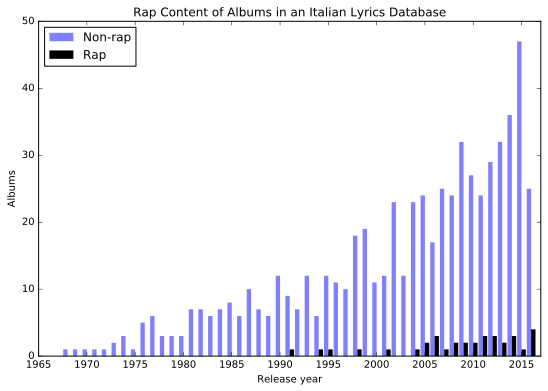

In [46]:
byyear = first_song_info.groupby(by=['year'])
totalalbums = byyear['song'].count()
totalrap = byyear['is_rap'].sum()
nonrap = totalalbums-totalrap
ind = totalalbums.index    # the x locations for the groups
width = 0.45 
plt.figure(figsize=[9,6])
rapcolours = [[0.5, 0.5, 1],[0, 0, 0]]
p1 = plt.bar(ind-width, nonrap, width, color=rapcolours[0],linewidth=0)
p2 = plt.bar(ind, totalrap, width, color=rapcolours[1],linewidth=0)
plt.xlim([1965,2017])
plt.xticks(range(1965,2020,5))
plt.ylabel('Albums')
plt.xlabel('Release year')
ax = plt.gca()
ax.get_yaxis().set_tick_params(direction='in')
ax.get_xaxis().set_tick_params(direction='in')
plt.draw()
plt.legend(['Non-rap','Rap'],loc='upper left')
plt.title('Rap Content of Albums in an Italian Lyrics Database')


There was some support for my hypothesis, since most of the rap albums in the database were from the last 10 years. Even when viewed as a proportion, though, there does not seem to be a consistent trend in the proportion of rap albums:

(1965, 2017)

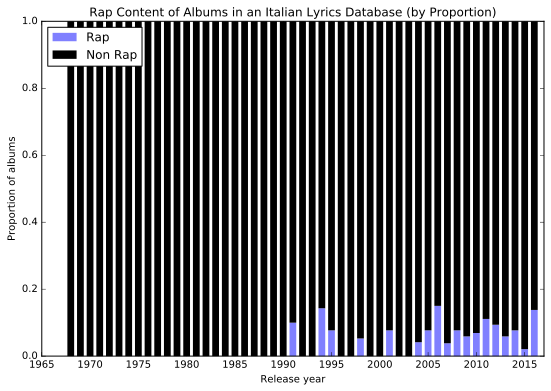

In [47]:
totalalbums = totalrap + nonrap
rapprops = np.array([totalrap/totalalbums,nonrap/totalalbums])

width = 0.7
plt.figure(figsize=[9,6])
lefts = ind-(0.5*width)
p1 = plt.bar(lefts, rapprops[0,:], width, color=rapcolours[0],linewidth=0)
p2 = plt.bar(lefts, rapprops[1,:], width, color=rapcolours[1], bottom=rapprops[0,:], linewidth=0)
plt.ylabel('Proportion of albums')
plt.xlabel('Release year')
plt.legend(['Rap','Non Rap'],loc='upper left')
plt.title('Rap Content of Albums in an Italian Lyrics Database (by Proportion)')

plt.xticks(range(1965,2020,5))
plt.xlim([1965,2017])


### Language content

As a secondary investigation, I used a pre-written language classifier (based on stopwords in the NTLK package) on the first songs, to see whether English-language albums were getting more popular with time relative to Italian albums, as another example of americanization of taste. The raw number of albums:

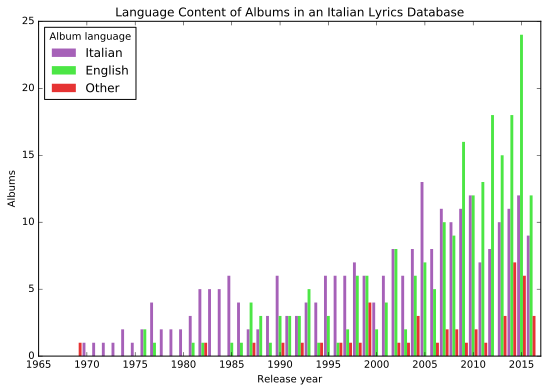

In [48]:
langcolours = np.array([[0.65,0.38,0.72],[0.3, 0.9, 0.27],[0.9,0.20,0.20]])

byyearlang = first_song_info.groupby(by=['year','language'])
languagereport = byyearlang['album'].count().unstack()
languagereport.loc[:,'other'] = np.nansum(languagereport.loc[:,['french','german','portuguese','spanish']],1)
years = languagereport.index
totalitalian = np.nan_to_num(languagereport.loc[:,'italian'])
totalenglish = np.nan_to_num(languagereport.loc[:,'english'])
totalother = np.nan_to_num(languagereport.loc[:,'other'])
width =0.3

plt.figure(figsize=[9,6])
p1 = plt.bar(years-(width+0.5*width), totalitalian, width, color=langcolours[0,:],linewidth=0)
p2 = plt.bar(years-(0.5*width), totalenglish, width, color=langcolours[1,:],linewidth=0)
p3 = plt.bar(years+(width-0.5*width), totalother, width, color=langcolours[2,:],linewidth=0)
plt.ylabel('Albums')
plt.xlabel('Release year')

plt.xlim([1965,2017])
plt.xticks(range(1965,2020,5))
plt.legend(['Italian','English','Other'],title='Album language',loc='upper left')
plt.title('Language Content of Albums in an Italian Lyrics Database')
ax = plt.gca()
ax.get_yaxis().set_tick_params(direction='in')
ax.get_xaxis().set_tick_params(direction='in')
plt.draw()

There are more English-language albums from recent years than Italian albums, and the trend is confirmed by the proportions:

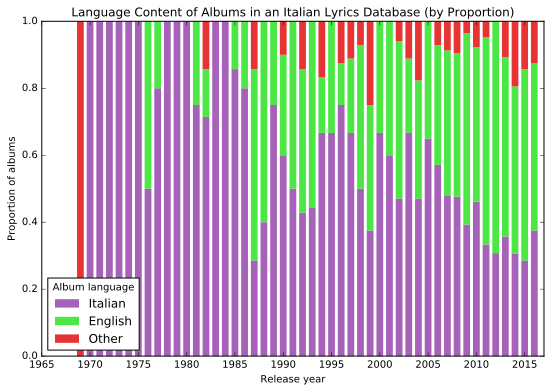

In [49]:
totalalbums = totalitalian + totalenglish + totalother
langprops = np.array([totalitalian/totalalbums,totalenglish/totalalbums,totalother/totalalbums])

width =0.7
plt.figure(figsize=[9,6])
lefts = years-(0.5*width)
p1 = plt.bar(lefts, langprops[0,:], width, color=langcolours[0,:],linewidth=0)
p2 = plt.bar(lefts, langprops[1,:], width, color=langcolours[1,:], bottom=langprops[0,:], linewidth=0)
p3 = plt.bar(lefts, langprops[2,:], width, color=langcolours[2,:], bottom=(langprops[1,:]+langprops[0,:]),linewidth=0)
plt.ylabel('Proportion of albums')
plt.xlabel('Release year')
plt.legend(['Italian','English','Other'],title='Album language',loc='lower left')
plt.title('Language Content of Albums in an Italian Lyrics Database (by Proportion)')

plt.xlim([1965,2017])
plt.xticks(range(1965,2020,5));

English albums become more represented relative to Italian albums as the publication dates come closer to the present, at least with more consistent growth in the last 10 years (which are also less volatile proportions because of the larger samples).

### Conclusion
Although a larger and more systematically sampled data set, especially one with genre tags, will give more accurate measures, to track cool - and especially to forecast it - messy, non-traditional data sources need to be exploited. 